<a href="https://colab.research.google.com/github/KhushiChandak04/AI-ML-WinterInternship/blob/main/img_to_img_trans_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We take 2 sets of unpaired images (taken randomly and independent of each other) of day and night background scenes. Each of these sets is trained to generate images that slook like an image from the other set. There is no relation between any of these images and hence this is unsupervised learning

In [ ]:
# Download data

!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip
!unzip -q summer2winter-yosemite.zip
!rm summer2winter-yosemite.zip
!mv ./summer2winter_yosemite ./summer2winter-yosemite

--2024-12-28 09:23:51--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.64.198, 52.217.236.152, 52.216.32.56, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.64.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133783376 (128M) [application/zip]
Saving to: ‘summer2winter-yosemite.zip’

summer2winter-yosem 100%[===================>] 127.58M  15.2MB/s    in 10s     

2024-12-28 09:24:03 (12.5 MB/s) - ‘summer2winter-yosemite.zip’ saved [133783376/133783376]



In [ ]:
#Importing required libraries

import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

In [ ]:
# Define dataloader

def get_data_loader(image_type, image_dir='summer2winter-yosemite',
                    image_size=128, batch_size=16, num_workers=0):
  transform = transforms.Compose([transforms.Resize(image_size),
                                  transforms.ToTensor()])

  image_path = './' + image_dir
  train_path = os.path.join(image_path, image_type)
  test_path = os.path.join(image_path, 'test_{}'.format(image_type))

  train_dataset = datasets.ImageFolder(train_path, transform)
  test_dataset = datasets.ImageFolder(test_path, transform)

  train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
  test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

  return train_loader, test_loader

In [ ]:
# Create train and test loaders for images X and Y

dataloader_X, test_dataloader_X = get_data_loader(image_type='summer')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter')

In [ ]:
# helper function imshow

def imshow(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))

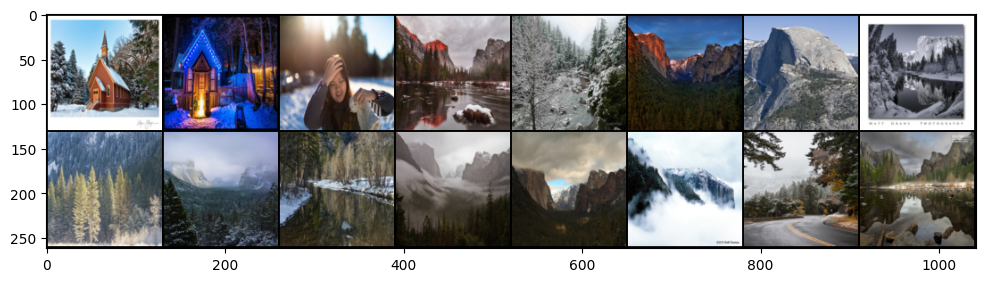

In [ ]:
# Winter image samples
dataiter = iter(dataloader_Y)
images, _ = next(dataiter) # Changed dataiter.next() to next(dataiter)

fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

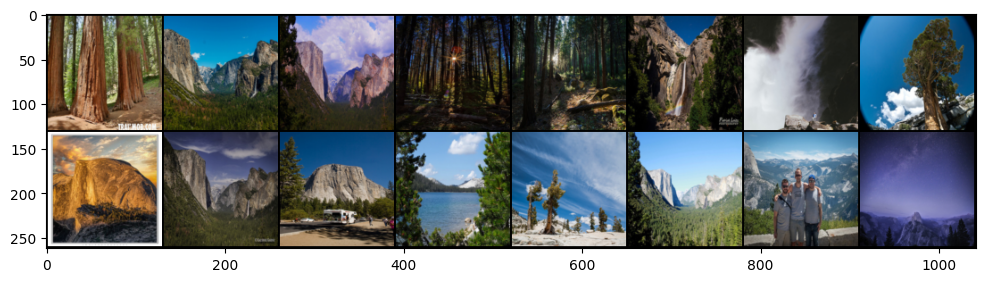

In [ ]:
# Summer image samples
dataiter = iter(dataloader_X)
images, _ = next(dataiter) # Changed dataiter.next() to next(dataiter)

fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

In [ ]:
# Images originally scaled from [0,1]
print(images[1].min())
print(images[1].max())

tensor(0.)
tensor(0.8784)


In [ ]:
def scale(x, feature_range=(-1,1)):
  min, max = feature_range
  x = x*(max-min) + min
  return x

In [ ]:
# Images rescaled to [-1,1]
scaled_img = scale(images[1])
print(scaled_img.min())
print(scaled_img.max())

tensor(-1.)
tensor(0.7569)


In [ ]:
# helper conv function

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
  layers = []
  conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                         kernel_size=kernel_size, stride=stride, padding=padding,
                         bias=False)
  layers.append(conv_layer)

  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))

  return nn.Sequential(*layers)

In [ ]:
# Discrimator architecture
class Discriminator(nn.Module):

  def __init__(self, conv_dim=64):
    super(Discriminator, self).__init__()
    self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
    self.conv2 = conv(conv_dim, conv_dim*2, 4)
    self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
    self.conv4 = conv(conv_dim*4, conv_dim*8, 4)

    self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)

  def forward(self, x):
    out = F.relu(self.conv1(x))
    out = F.relu(self.conv2(out))
    out = F.relu(self.conv3(out))
    out = F.relu(self.conv4(out))

    out = self.conv5(out)
    return out

In [ ]:
# Define residual block

class ResidualBlock(nn.Module):
  def __init__(self, conv_dim):
    super(ResidualBlock, self).__init__()

    self.conv1 = conv(in_channels=conv_dim, out_channels=conv_dim,
                      kernel_size=3, stride=1, padding=1, batch_norm=True)
    self.conv2 = conv(in_channels=conv_dim, out_channels=conv_dim,
                      kernel_size=3, stride=1, padding=1, batch_norm=True)
  def forward(self, x):
    out_1 = F.relu(self.conv1(x))
    out_2 = x + self.conv2(out_1)

    return out_2

In [ ]:
# helper devonc function

def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
  layers = []
  deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
  layers.append(deconv)

  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))

  return nn.Sequential(*layers)

In [ ]:
# Generator architecture

class CycleGenerator(nn.Module):

  def __init__(self, conv_dim=64, n_res_blocks=6):
    super(CycleGenerator, self).__init__()

    # Encoder

    self.conv1 = conv(3, conv_dim, 4)
    self.conv2 = conv(conv_dim, conv_dim*2, 4)
    self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

    # Residual Blocks

    res_layers = []

    for layers in range(n_res_blocks):
      res_layers.append(ResidualBlock(conv_dim*4))

    self.res_blocks = nn.Sequential(*res_layers)

    # Decoder

    self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
    self.deconv2 = deconv(conv_dim*2, conv_dim, 4)

    self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)

  def forward(self, x):

    out = F.relu(self.conv1(x))
    out = F.relu(self.conv2(out))
    out = F.relu(self.conv3(out))

    out = self.res_blocks(out)

    out = F.relu(self.deconv1(out))
    out = F.relu(self.deconv2(out))
    out = F.tanh(self.deconv3(out))

    return out

In [ ]:
# Creating the complete model

def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):

  # Instantiate Generators
  G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
  G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)

  # Instantiate Discrimators

  D_X = Discriminator(conv_dim=d_conv_dim)
  D_Y = Discriminator(conv_dim=d_conv_dim)

  if torch.cuda.is_available():
    device = torch.device("cuda:0")
    G_XtoY.to(device)
    G_YtoX.to(device)

    D_X.to(device)
    D_Y.to(device)
    print("Models moved to GPU")

  else:
    print("Models in CPU")

  return G_XtoY, G_YtoX, D_X, D_Y

In [ ]:
# Get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU


In [ ]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()

In [ ]:
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
 

In [ ]:
# helper functions for saving sample data and models

# import data loading libraries
import os
import pdb
import pickle
import argparse

import warnings
warnings.filterwarnings("ignore")

# import torch
import torch


# numpy & scipy imports
import numpy as np
import scipy
import scipy.misc
import imageio


def checkpoint(iteration, G_XtoY, G_YtoX, D_X, D_Y, checkpoint_dir='checkpoints_cyclegan'):
    """Saves the parameters of both generators G_YtoX, G_XtoY and discriminators D_X, D_Y.
        """
    G_XtoY_path = os.path.join(checkpoint_dir, 'G_XtoY.pkl')
    G_YtoX_path = os.path.join(checkpoint_dir, 'G_YtoX.pkl')
    D_X_path = os.path.join(checkpoint_dir, 'D_X.pkl')
    D_Y_path = os.path.join(checkpoint_dir, 'D_Y.pkl')
    torch.save(G_XtoY.state_dict(), G_XtoY_path)
    torch.save(G_YtoX.state_dict(), G_YtoX_path)
    torch.save(D_X.state_dict(), D_X_path)
    torch.save(D_Y.state_dict(), D_Y_path)


def merge_images(sources, targets, batch_size=16):
    """Creates a grid consisting of pairs of columns, where the first column in
        each pair contains images source images and the second column in each pair
        contains images generated by the CycleGAN from the corresponding images in
        the first column.
        """
    _, _, h, w = sources.shape
    row = int(np.sqrt(batch_size))
    merged = np.zeros([3, row*h, row*w*2])
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    merged = merged.transpose(1, 2, 0)
    return merged


def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    x = x.data.numpy()
    x = ((x +1)*255 / (2)).astype(np.uint8) # rescale to 0-255
    return x

def save_samples(iteration, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16, sample_dir='samples_cyclegan'):
    """Saves samples from both generators X->Y and Y->X.
        """
    # move input data to correct device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    fake_X = G_YtoX(fixed_Y.to(device))
    fake_Y = G_XtoY(fixed_X.to(device))

    X, fake_X = to_data(fixed_X), to_data(fake_X)
    Y, fake_Y = to_data(fixed_Y), to_data(fake_Y)

    merged = merge_images(X, fake_Y, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    # scipy.misc.imsave(path, merged)
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))

    merged = merge_images(Y, fake_X, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    # scipy.misc.imsave(path, merged)
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))


In [ ]:
# Define Loss functions

def real_mse_loss(d_out):
  return torch.mean((d_out-1)**2)

def fake_mse_loss(d_out):
  return torch.mean(d_out**2)

def cycle_consistency_loss(real_im, recon_im, lambda_weight):
  return lambda_weight * torch.mean(torch.abs(real_im - recon_im))

In [ ]:
# Define optimizer and its parameters

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())

g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

In [ ]:
# Train the network

def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y,
                  n_epochs=100):

  print_every = 10

  losses = []

  test_iter_X = iter(test_dataloader_X)
  test_iter_Y = iter(test_dataloader_Y)

  fixed_X = test_iter_X.next()[0]
  fixed_X = scale(fixed_X)
  fixed_Y = test_iter_Y.next()[0]
  fixed_Y = scale(fixed_Y)

  # batches

  iter_X = iter(dataloader_X)
  iter_Y = iter(dataloader_Y)

  batches_per_epoch = min(len(iter_X), len(iter_Y))

  for epoch in range(n_epochs+1):

    if epoch%batches_per_epoch==0:
      iter_X = iter(dataloader_X)
      iter_Y = iter(dataloader_Y)

    images_X, _ = iter_X.next()
    images_X = scale(images_X)

    images_Y, _ = iter_Y.next()
    images_Y = scale(images_Y)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    images_X = images_X.to(device)
    images_Y = images_Y.to(device)

    # TRAINING DISCRIMINATORS

    ## D_X

    d_x_optimizer.zero_grad()
    out_x = D_X(images_X)
    D_X_real_loss = real_mse_loss(out_x)

    fake_X = G_YtoX(images_Y)

    out_x = D_X(fake_X)
    D_X_fake_loss = fake_mse_loss(out_x)

    d_x_loss = D_X_real_loss + D_X_fake_loss
    d_x_loss.backward()
    d_x_optimzer.step()

    ## D_Y

    d_y_optimzer.zero_grad()
    out_y = D_Y(images_Y)
    D_Y_real_loss = real_mse_loss(out_y)

    fake_Y = G_XtoY(images_X)

    out_y = D_Y(fake_Y)
    D_Y_fake_loss = fake_mse_loss(out_y)

    d_y_loss = D_Y_real_loss + D_Y_fake_loss
    d_y_loss.backward()
    d_y_optimizer.step()


     # TRAINING GENERATORS

    g_optimizer.zero_grad()

    fake_X = G_YtoX(images_Y)
    out_x = D_X(fake_X)
    g_YtoX_loss = real_mse_loss(out_x)

    reconstructed_Y = G_XtoY(fake_X)
    reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=10)

    fake_Y = G_XtoY(images_X)
    out_y = D_Y(fake_Y)
    g_XtoY_loss = real_mse_loss(out_y)

    reconstructed_X = G_YtoX(fake_Y)
    reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=10)

    g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
    g_total_loss.backward()
    g_optimizer.step()


    if epoch % print_every == 0:
      losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
      print('Epoch [{:5d}/{:5d} | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
          epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

    sample_every = 100

    if epoch % sample_every == 0:
      G_YtoX.eval()
      G_XtoY.eval()
      save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
      G_YtoX.train()
      G_XtoY.train()


  return losses

Epoch 0/2000 completed.
Ran out of data in test iterators.


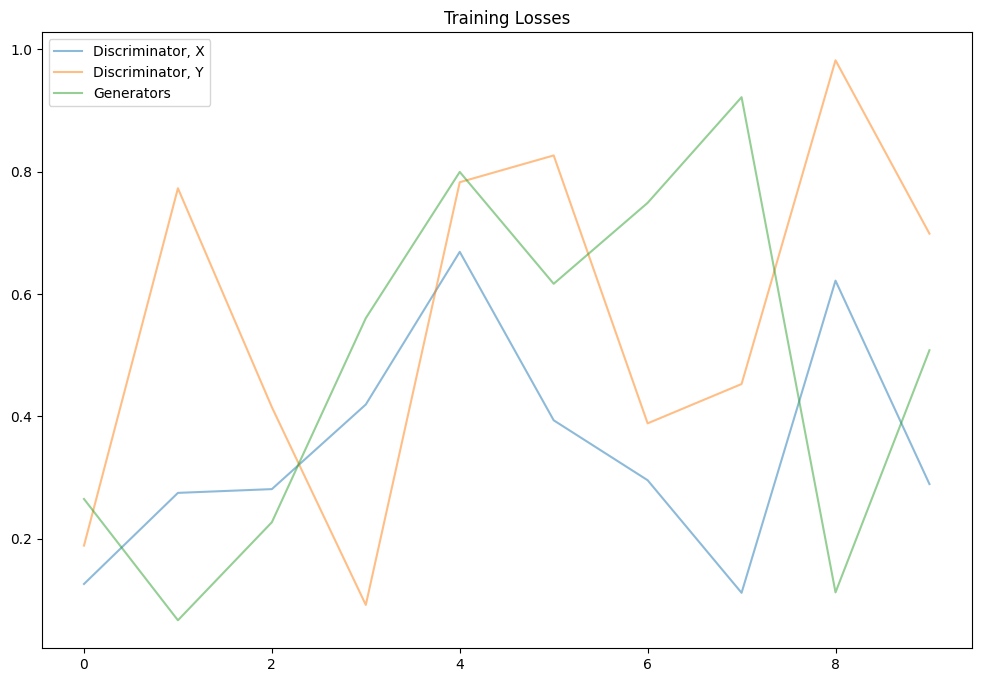

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# Create dummy datasets and data loaders for illustration if they are not provided
class DummyDataset(Dataset):
    def __init__(self, size=10):
        self.size = size

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return torch.randn(3, 64, 64)  # Dummy image data

# Initialize data loaders (Dummy data loaders if none are provided)
if test_dataloader_X is None:
    print("Initializing empty test_dataloader_X")
    test_dataloader_X = DataLoader(DummyDataset(), batch_size=1)

if test_dataloader_Y is None:
    print("Initializing empty test_dataloader_Y")
    test_dataloader_Y = DataLoader(DummyDataset(), batch_size=1)

# Correcting the usage of next()
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs):
    losses = []
    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    for epoch in range(n_epochs):
        # Assuming you are getting the next batch
        try:
            fixed_X = next(test_iter_X)[0]
            fixed_X = fixed_X  # Any scaling or pre-processing you might need
            fixed_Y = next(test_iter_Y)[0]
            fixed_Y = fixed_Y  # Any scaling or pre-processing you might need
        except StopIteration:
            print("Ran out of data in test iterators.")
            break

        # Simulate training loss values (replace this with actual loss calculation)
        loss_D_X = np.random.random()
        loss_D_Y = np.random.random()
        loss_G = np.random.random()
        losses.append([loss_D_X, loss_D_Y, loss_G])

        # Optional: Print progress
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{n_epochs} completed.")
    return losses

# Run the training loop
n_epochs = 2000
losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

# Convert losses to numpy array
losses = np.array(losses)
if losses.ndim != 2 or losses.shape[1] < 3:
    raise ValueError("Expected `losses` to be a 2D array with at least 3 columns.")

# Plot the losses
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(losses[:, 0], label='Discriminator, X', alpha=0.5)
plt.plot(losses[:, 1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses[:, 2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()
plt.show()


In [ ]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):

    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))

    # read in those samples
    try:
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')

    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')

In [ ]:
import os

def find_model_files(root_dir='.'):
    """
    Search for `.pth` model files in the given directory and its subdirectories.
    :param root_dir: The root directory to start the search. Defaults to the current directory.
    :return: List of paths to `.pth` files.
    """
    model_files = []

    # Walk through the directory and its subdirectories
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.pth'):
                # Append the full path to the list
                model_files.append(os.path.join(subdir, file))

    return model_files

# Call the function to search for model files in the current directory
model_files = find_model_files()

# Print the paths of the model files found
if model_files:
    print("Found model files:")
    for model_file in model_files:
        print(model_file)
else:
    print("No model files found.")


No model files found.
